In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout

Definition of a plot function for training result visualization

In [ ]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)
    
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)
    
    plt.show();

## Preprocessing of the data

We get the IMDB dataset directly from the tensorflow_datasets API and we do the usual preprocessing before feeding a neural network

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

train_size = info.splits["train"].num_examples
batch_size = 32

train_set = datasets["train"].shuffle(10000).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_size = info.splits["test"].num_examples
test_set = datasets["test"].repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Use of a pretrained embedding

We use of pretrained embedding directly from tensorflow_hub

In [ ]:
embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1")

We test on two (famous) lines and check the shapes of the embedding results

In [ ]:
embeddings = embed(["A thing of beauty is a joy forever", "If by dull rhymes our English must be chain'd"])
print(embeddings)
print(embeddings.shape)

tf.Tensor(
[[ 0.03275988  0.18106811  0.13030443  0.05100623  0.12367279 -0.11072872
   0.1655957  -0.0049278  -0.3281556   0.05204761  0.17150185  0.01282718
  -0.09332222  0.1672171  -0.05711355 -0.22492586 -0.15962309 -0.00958291
  -0.11166596 -0.42931503 -0.0194127  -0.20494537  0.25295272  0.05954154
  -0.25411132  0.12579551 -0.16218384 -0.10604351  0.27133545 -0.15765025
  -0.31424785  0.21318786 -0.10896667  0.14070608 -0.24665987  0.1579746
   0.24865562  0.04819695  0.10051076 -0.24969979  0.15491936 -0.0360333
   0.07346644  0.10915987 -0.08220651  0.12550174  0.16840625 -0.01693668
   0.0715794  -0.04162662]
 [ 0.16800539  0.24028125 -0.30071175  0.07007764 -0.18024668  0.07986181
   0.05427119 -0.28110817 -0.22582981  0.26624134  0.13623291 -0.11988997
   0.16064322 -0.04873525 -0.08858649 -0.15337813  0.00109797 -0.26315662
   0.3372981  -0.14884004  0.17933601 -0.12853579 -0.15982151 -0.10252967
  -0.03884843  0.08044805 -0.20275603 -0.17167023  0.20971875 -0.12899558
  

## Neural network model definition

Build a neural network using keras sequential layers

(you may have a look at https://keras.io/api/layers/)

In [ ]:
model = tf.keras.models.Sequential([
    hub.KerasLayer(embed,
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    Dense(128, activation="relu"),
    #Dropout(rate=0.8),
    Dense(300, activation="relu"),
    #Dropout(rate=0.8),
    Dense(1, activation="sigmoid")
])

We check that everything is fine with the model as we defined it

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_15 (Dense)             (None, 128)               6528      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 300)               38700     
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 301       
Total params: 48,236,129
Trainable params: 45,529
Non-trainable params: 48,190,600
_____________________________________

We compile the model, choosing relevant loss function, optimizer and metrics

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

We train the model on the dataset

In [ ]:
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=100, validation_data=test_set, validation_steps=test_size // batch_size)

Epoch 1/100
781/781 [==============================] - 12s 14ms/step - loss: 0.6435 - accuracy: 0.6280 - val_loss: 0.5619 - val_accuracy: 0.7247
Epoch 2/100
781/781 [==============================] - 11s 14ms/step - loss: 0.5826 - accuracy: 0.6995 - val_loss: 0.5436 - val_accuracy: 0.7359
Epoch 3/100
781/781 [==============================] - 11s 14ms/step - loss: 0.5654 - accuracy: 0.7157 - val_loss: 0.5347 - val_accuracy: 0.7385
Epoch 4/100
781/781 [==============================] - 11s 14ms/step - loss: 0.5565 - accuracy: 0.7256 - val_loss: 0.5275 - val_accuracy: 0.7412
Epoch 5/100
781/781 [==============================] - 11s 14ms/step - loss: 0.5488 - accuracy: 0.7285 - val_loss: 0.5290 - val_accuracy: 0.7427
Epoch 6/100
781/781 [==============================] - 11s 14ms/step - loss: 0.5467 - accuracy: 0.7310 - val_loss: 0.5239 - val_accuracy: 0.7428
Epoch 7/100
781/781 [==============================] - 11s 14ms/step - loss: 0.5434 - accuracy: 0.7316 - val_loss: 0.5224 - val_ac

## Result visualization

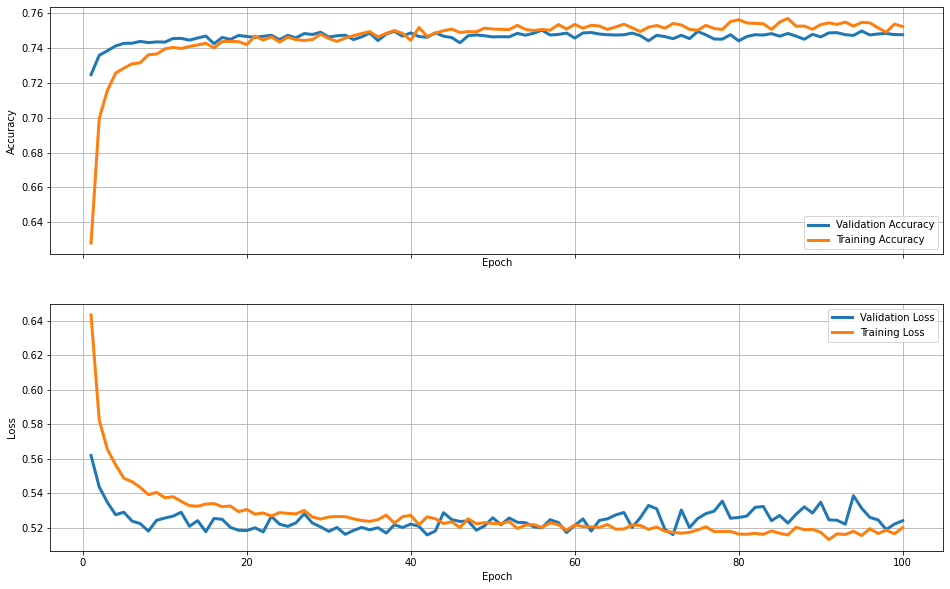

In [ ]:
plot_results(history)